# Plots of the results

This notebook contains the plots of the results of the assignment 2 of the Foundations of HPC course.
All results are compared to the theoretical peak performance of the orfeo nodes. The theoretical peak performance can be computed as:
$$Flops_{peak} = n_{cores} \times frequency \times (\frac{FLOP}{cycle})$$

### AMD EPYC™ 7H12

- $n_{cores} = 64$
- $frequency = 2.6$ GHz
- AMD Epyc 7H12 can reach at most $\frac{FLOP}{cycle} = 32$ operations per second regarding the floating point (single precision) operations and $\frac{FLOP}{cycle} = 16$ operations per second for the double precision operations.
- The theoretical peak performance is then $64 \times 2.6 \times 32 =  5324.8$ GFlops for single precision and $64 \times 2.6 \times 16 = 2662.4$ GFlops for double precision.

### Intel® Xeon® Gold 6126

- $n_{cores} = 12$
- $frequency = 2.6$ GHz
- Intel Xeon Gold 6126 can reach at most $\frac{FLOP}{cycle} = 32$ operations per second regarding the floating point (single precision) operations and $\frac{FLOP}{cycle} = 16$ operations per second for the double precision operations.
- The theoretical peak performance is then $24 \times 2.6 \times 32 =  1996.8$ GFlops for single precision (this result is coherent with the data provided in the course material) and $24 \times 2.6 \times 16 = 998.4$ GFlops for double precision.
- In this case, also the theoretical peak performance with the Max Turbo Frequency ($3.7$ GHz, frequency at which the processor is capable of operating using Intel® Turbo Boost Technology) is computed for analytical purposes: $24 \times 3.7 \times 32 =  2841.6$ GFlops for single precision and $24 \times 3.7 \times 16 = 1420.8$ GFlops for double precision.

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

For each test, the corresponding statistics and indexes are computed, grouping the observations by size (or by the number of used cores). The results are then plotted in a line plot, with the statistics on the y-axis, and either the matrix size or the number of used cores on the x axis.

In [72]:
# This function summarizes the results of the experiments, preparing them for plotting

def get_summary(test = 'size_scaling', lib = 'mkl', node = "EPYC", precision = "float", policy = "spread"):

    match test:

        case 'size_scaling':
            ## Load data
            data_path = f"results/size_scaling/size_scaling_{node}_{lib}_{precision}_{policy}.csv"
            data = pd.read_csv(data_path)
            
            ## Compute mean gflops grouped by matrix size
            summary = data.groupby(['size']).mean('gflops').reset_index()
            return summary
        
        case 'core_scaling':
            ## Load data
            data_path = f"results/core_scaling/core_scaling_{node}_{lib}_{precision}_{policy}.csv"
            data = pd.read_csv(data_path)

            ## Compute mean time grouped by matrix size
            summary = data.groupby(['n_cores']).mean('time').reset_index()

            ## Compute speedup
            summary['speedup'] = summary['time'][0]/summary['time']

            ## Compute efficiency
            summary['efficiency'] = summary['speedup']/summary['n_cores']
            return summary
        
            

# Size scaling

### EPYC nodes - single precision

In [73]:
# Gather data for the plot

node = 'EPYC'
precision = 'float'

policy = 'spread'
ss_mkl_float_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_float_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_float_spread['test'] = 'MKL - spread'
ss_oblas_float_spread['test'] = 'OpenBLAS - spread'
ss_mkl_float_close['test'] = 'MKL - close'
ss_oblas_float_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes
ss_epyc_float = pd.concat([
    ss_mkl_float_spread, 
    ss_oblas_float_spread, 
    ss_mkl_float_close, 
    ss_oblas_float_close
    ])

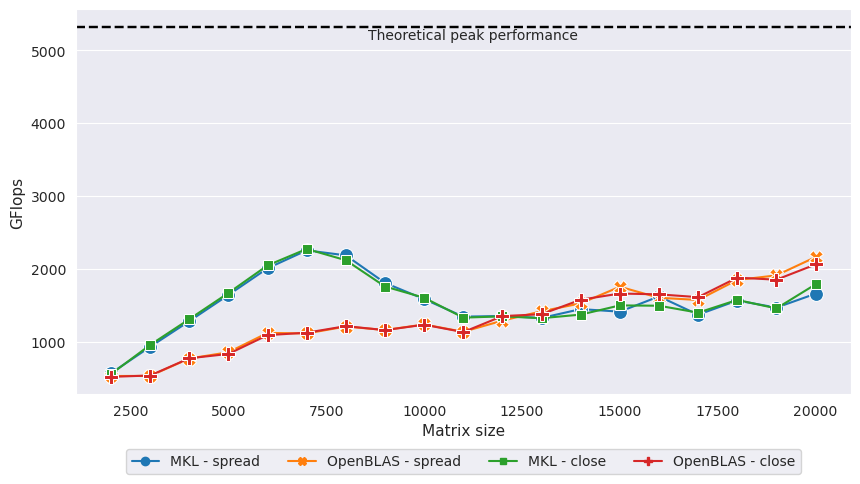

In [94]:
# Plot the results

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_epyc_float, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
plt.axhline(y=5324.8, color='black', linestyle='--', linewidth=1.75) ## Theoretical peak performance line
plt.text(x=11250, y=5210, s='Theoretical peak performance', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_epyc_float.png', dpi=250, bbox_inches='tight')
plt.show()

None of the libraries reaches the theoretical peak performance. This may be due to several factors: communication overhead, memory bandwidth, ... it might be beneficial to explore additional factors such as communication patterns, cache utilization, and memory bandwidth utilization in order to understand the reasons behind this and to improve the performance of the code.

OpenBLAS shows better results with bigger matrices, while MKL seems better with small matrices. This could be attributed to the specific optimizations and parallelization strategies employed by each library. An improvement could be to use a different library depending on the size of the matrix.

Changing binding policy doesn't seem to do much, independently on the chosen library, the distribution of computational workloads across physical cores may not be a critical factor on the AMD EPYC 7H12 processor, the performance of the code is not highly sensitive to how the computational tasks are spread or kept close to each other in terms of physical core placement.<br>
This also suggests that the specific placement of threads on cores (the thread affinity), does not play a major role in influencing the overall performance of this parallel code.<br>
On a NUMA architecture, memory access patterns are influenced by thread and core placement. This lack of sensitivity to the binding policy may indicate that the code is not strongly affected by NUMA effects.<br>

## EPYC nodes - double precision

In [75]:
# Gather data for the plot

node = 'EPYC'
precision = 'double'

policy = 'spread'
ss_mkl_double_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_double_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_double_spread['test'] = 'MKL - spread'
ss_oblas_double_spread['test'] = 'OpenBLAS - spread'
ss_mkl_double_close['test'] = 'MKL - close'
ss_oblas_double_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes
ss_epyc_double = pd.concat([
    ss_mkl_double_spread, 
    ss_oblas_double_spread, 
    ss_mkl_double_close, 
    ss_oblas_double_close
    ])

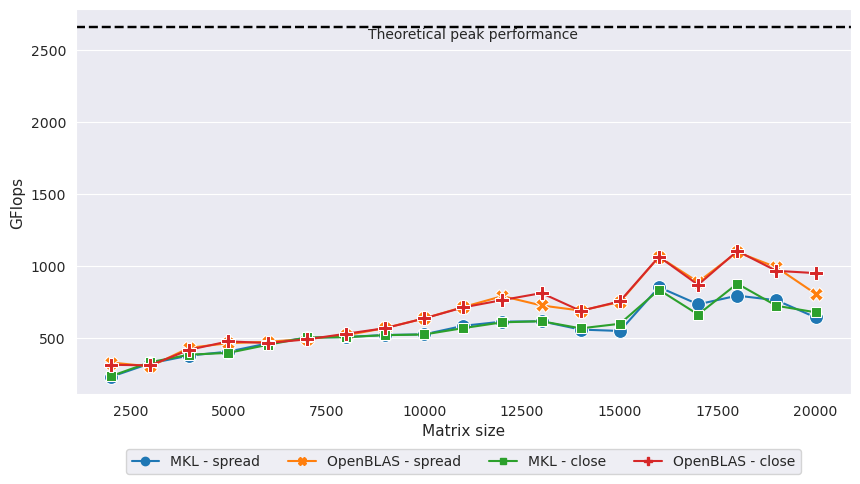

In [95]:
# Plot the results

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_epyc_double, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
plt.axhline(y=2662.4, color='black', linestyle='--', linewidth=1.75) ## Theoretical peak performance line
plt.text(x=11250, y=2610, s='Theoretical peak performance', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_epyc_double.png', dpi=250, bbox_inches='tight')
plt.show()

Same considerations as before, but here MKL doesn't show a better performance with small matrices.

## THIN nodes - single precision

In [77]:
# Gather data for the plot
node = 'THIN'
precision = 'float'

policy = 'spread'
ss_mkl_float_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_float_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_float_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_float_spread['test'] = 'MKL - spread'
ss_oblas_float_spread['test'] = 'OpenBLAS - spread'
ss_mkl_float_close['test'] = 'MKL - close'
ss_oblas_float_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes
ss_thin_float = pd.concat([
    ss_mkl_float_spread, 
    ss_oblas_float_spread, 
    ss_mkl_float_close, 
    ss_oblas_float_close
    ])

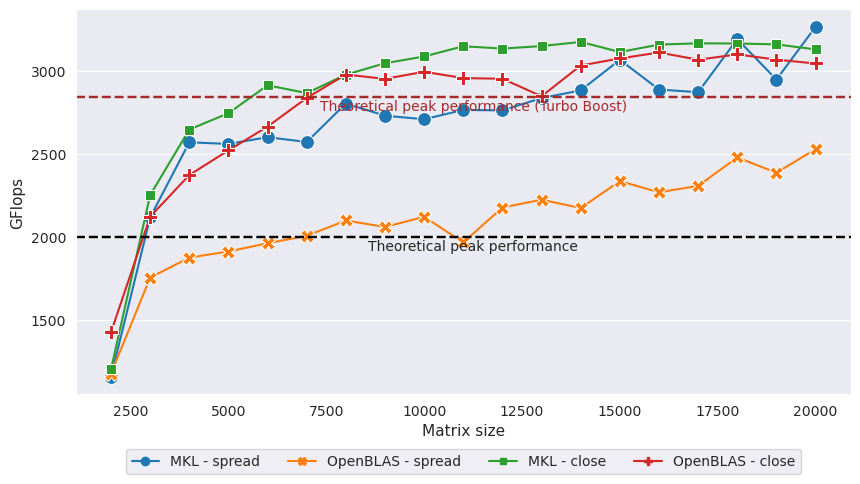

In [93]:
# Plot the results

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_thin_float, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
plt.axhline(y=1996.8, color='black', linestyle='--', linewidth=1.75) ## Theoretical peak performance line
plt.text(x=11250, y=1944, s='Theoretical peak performance', va='center', ha='center')
plt.axhline(y=2841.6, color='brown',linestyle='--', linewidth=1.75) ## Theoretical peak performance line (Turbo Boost)
plt.text(x=11250, y=2785, s='Theoretical peak performance (Turbo Boost)', va='center', ha='center', color='brown')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_thin_float.png', dpi=250, bbox_inches='tight')
plt.show()

WARNING: MAYBE THERE IS AN ERROR WITH THESE TESTS, CHECK AND RUN AGAIN.

The performance here seems to go over the theoretical peak, this may be due to the fact that the processor went into turbo mode.

The observed performance is even higher than the theoretical peak performance in the case of Turbo Boost, this may be due to caching effects.

Also, the binding policy seems to have a bigger impact on these nodes, for both libraries. The performance is better with the close policy, when the processes are assigned to phisically close cores.

## THIN nodes - double precision

In [79]:
# Gather data for the plot

node = 'THIN'
precision = 'double'

policy = 'spread'
ss_mkl_double_spread = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_spread = get_summary(
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
ss_mkl_double_close = get_summary(
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
ss_oblas_double_close = get_summary(
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
ss_mkl_double_spread['test'] = 'MKL - spread'
ss_oblas_double_spread['test'] = 'OpenBLAS - spread'
ss_mkl_double_close['test'] = 'MKL - close'
ss_oblas_double_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes
ss_thin_double = pd.concat([
    ss_mkl_double_spread, 
    ss_oblas_double_spread, 
    ss_mkl_double_close, 
    ss_oblas_double_close
    ])

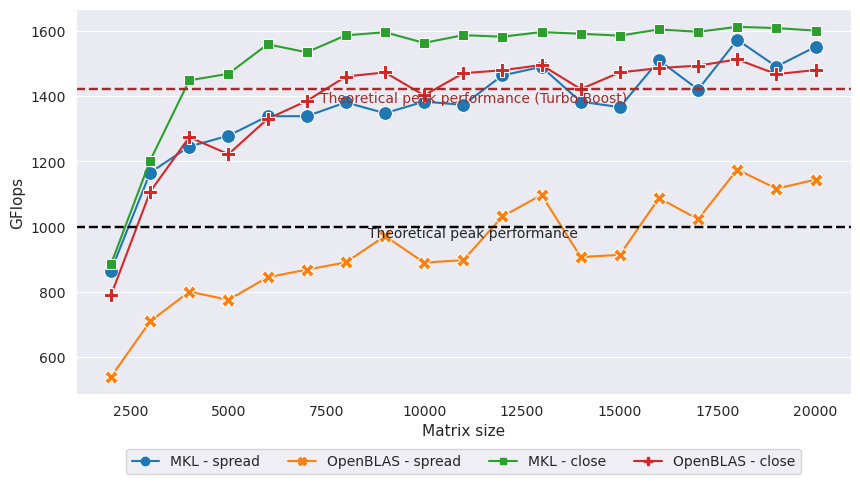

In [96]:
# Plot the results

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='size',
             y='gflops', 
             hue='test', 
             data=ss_thin_double, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
plt.axhline(y=998.4, color='black', linestyle='--', linewidth=1.75) ## Theoretical peak performance line
plt.text(x=11250, y=980, s='Theoretical peak performance', va='center', ha='center')
plt.axhline(y=1420.8, color='brown',linestyle='--', linewidth=1.75) ## Theoretical peak performance line (Turbo Boost)
plt.text(x=11250, y=1395, s='Theoretical peak performance (Turbo Boost)', va='center', ha='center', color='brown')
## Styling
sns.set_style('darkgrid')
plt.ylabel('GFlops', fontsize=11)
plt.xlabel('Matrix size', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/size_scaling_thin_double.png', dpi=250, bbox_inches='tight')
plt.show()

WARNING: MAYBE THERE IS AN ERROR WITH THESE TESTS, CHECK AND RUN AGAIN.

Same considerations as before.

On THIN nodes, the MKL library seems to perform better than OpenBLAS, independently on the matrix size and the number of used cores. This may be due to the fact that MKL is an Intel library and maybe it's optimized for their processors.

On EPYC nodes, the performance of the two libraries is comparable, but OpenBLAS seems to perform better with bigger matrices.

# Core scaling

To analyze the results, two indexes are going to be considered:
- Speedup: $S(n, t) = \frac{T_{s}(n)}{T_{p}(n)}$
    - The speedup measures how much faster the parallel algorithm is compared to the sequential one.
    - $p$ is the number of used cores.
    - $T_{s}(n)$ is the time taken by the sequential algorithm.
    - $T_{p}(n)$ is the time taken by the parallel algorithm.
- Efficiency: $E(n, t) = \frac{S(n, t)}{p}$
    - The efficiency measures the percentage of time for which a processor is utilized effectively.

The theorical maximum speedup is $p$, while the maximum efficiency is $1$.


## EPYC nodes - single precision

In [81]:
# Gather data for the plot

node = 'EPYC'
precision = 'float'

policy = 'spread'
cs_mkl_float_spread = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_float_spread = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
cs_mkl_float_close = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_float_close = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
cs_mkl_float_spread['test'] = 'MKL - spread'
cs_oblas_float_spread['test'] = 'OpenBLAS - spread'
cs_mkl_float_close['test'] = 'MKL - close'
cs_oblas_float_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes
cs_epyc_float = pd.concat([
    cs_mkl_float_spread, 
    cs_oblas_float_spread, 
    cs_mkl_float_close, 
    cs_oblas_float_close
    ])

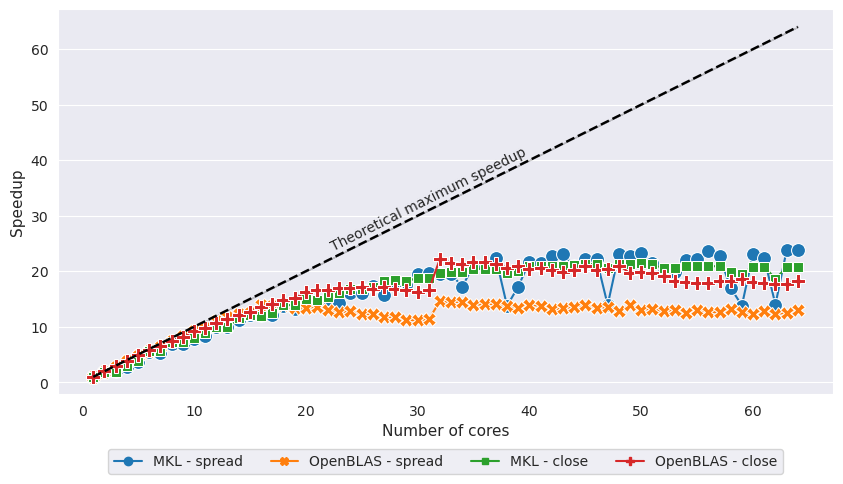

In [82]:
# Plot the results - speedup

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='n_cores',
             y='speedup', 
             hue='test', 
             data=cs_epyc_float, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
## Theoretical maximum speedup line
sns.lineplot(x='n_cores', y='n_cores', data=cs_epyc_float, color='black', linestyle='--', linewidth=1.75)
plt.text(x=31, y=33, s='Theoretical maximum speedup', va='center', ha='center', rotation=45, rotation_mode='anchor', transform_rotates_text=True)
## Styling
sns.set_style('darkgrid')
plt.ylabel('Speedup', fontsize=11)
plt.xlabel('Number of cores', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/core_scaling_epyc_float.png', dpi=250, bbox_inches='tight')
plt.show()

The trend is clearly sublinear, as the number of cores increases, the overhead of parallelization, such as communication and synchronization, becomes more pronounced, limiting the overall speedup.

By looking at the plot, it seems that after the 16th core, the accelleration in the speedup starts decreasing. This is probably due to the communication overhead introduced at higher core counts.

Also, Amdahl's Law states that the speedup of a program is limited by the proportion of the code that cannot be parallelized, which cannot benefit from the improvement.

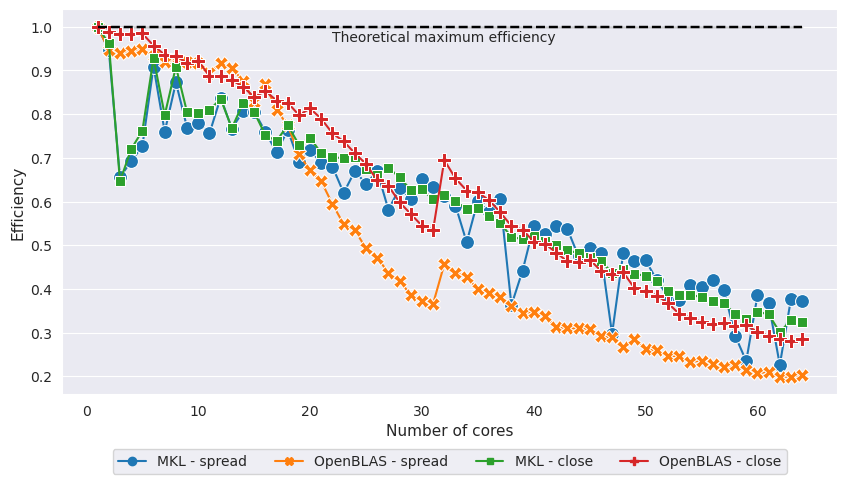

In [83]:
# Plot the results - efficiency

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='n_cores',
             y='efficiency', 
             hue='test', 
             data=cs_epyc_float, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
## Theoretical maximum efficiency line
sns.lineplot(x='n_cores', y=1, data=cs_epyc_float, color='black', linestyle='--', linewidth=1.75)
plt.text(x=32, y=0.975, s='Theoretical maximum efficiency', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('Efficiency', fontsize=11)
plt.xlabel('Number of cores', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/core_scaling_epyc_float_efficiency.png', dpi=250, bbox_inches='tight')
plt.show()

Efficiency tends to decrease while increasing the number of cores, this is due to the fact that the workload is not evenly distributed among the cores, some cores may finish their tasks early and be idle waiting for others to complete, decreasing efficiency. Beyond a certain point, adding more cores might not provide substantial benefits.

The steeper decrease in efficiency at higher core counts suggests that there may be a critical point where the overhead becomes more significant or the workload distribution becomes less balanced. This could be due to factors like increased contention for shared resources or increased communication costs.

Optimizing communication patterns, load balancing, and minimizing synchronization points may improve the scalability of this code.

## EPYC nodes - double precision

In [84]:
# Gather data for the plot

node = 'EPYC'
precision = 'double'

policy = 'spread'
cs_mkl_double_spread = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_double_spread = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
cs_mkl_double_close = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_double_close = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
cs_mkl_double_spread['test'] = 'MKL - spread'
cs_oblas_double_spread['test'] = 'OpenBLAS - spread'
cs_mkl_double_close['test'] = 'MKL - close'
cs_oblas_double_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes
cs_epyc_double = pd.concat([
    cs_mkl_double_spread, 
    cs_oblas_double_spread, 
    cs_mkl_double_close, 
    cs_oblas_double_close
    ])

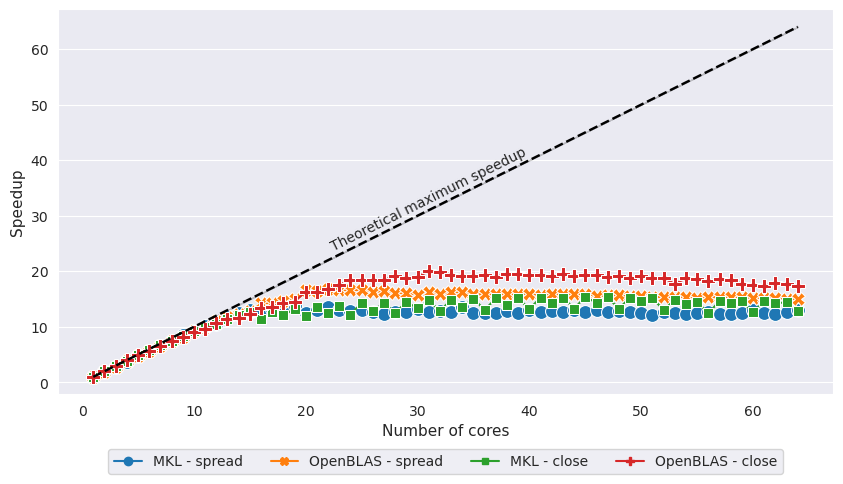

In [85]:
# Plot the results - speedup

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='n_cores',
             y='speedup', 
             hue='test', 
             data=cs_epyc_double, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
## Theoretical maximum speedup line
sns.lineplot(x='n_cores', y='n_cores', data=cs_epyc_double, color='black', linestyle='--', linewidth=1.75)
plt.text(x=31, y=33, s='Theoretical maximum speedup', va='center', ha='center', rotation=45, rotation_mode='anchor', transform_rotates_text=True)
## Styling
sns.set_style('darkgrid')
plt.ylabel('Speedup', fontsize=11)
plt.xlabel('Number of cores', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/core_scaling_epyc_double.png', dpi=250, bbox_inches='tight')
plt.show()


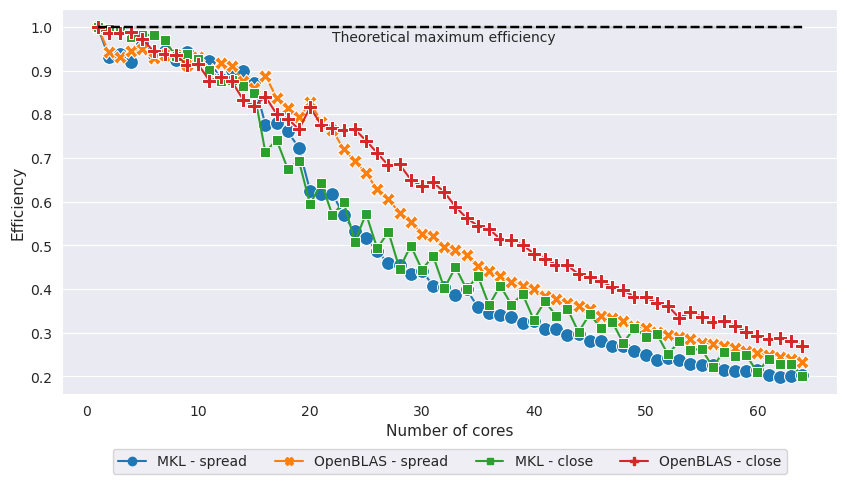

In [86]:
# Plot the results - efficiency

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='n_cores',
             y='efficiency', 
             hue='test', 
             data=cs_epyc_double, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
## Theoretical maximum efficiency line
sns.lineplot(x='n_cores', y=1, data=cs_epyc_double, color='black', linestyle='--', linewidth=1.75)
plt.text(x=32, y=0.975, s='Theoretical maximum efficiency', va='center', ha='center')
## Styling
sns.set_style('darkgrid')
plt.ylabel('Efficiency', fontsize=11)
plt.xlabel('Number of cores', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/core_scaling_epyc_double_efficiency.png', dpi=250, bbox_inches='tight')
plt.show()

The same considerations as before apply here.

## THIN nodes - single precision

In [87]:
# Gather data for the plot

node = 'THIN'
precision = 'float'

policy = 'spread'
cs_mkl_float_spread = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_float_spread = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
cs_mkl_float_close = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_float_close = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
cs_mkl_float_spread['test'] = 'MKL - spread'
cs_oblas_float_spread['test'] = 'OpenBLAS - spread'
cs_mkl_float_close['test'] = 'MKL - close'
cs_oblas_float_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes

cs_thin_float = pd.concat([
    cs_mkl_float_spread, 
    cs_oblas_float_spread, 
    cs_mkl_float_close, 
    cs_oblas_float_close
    ])

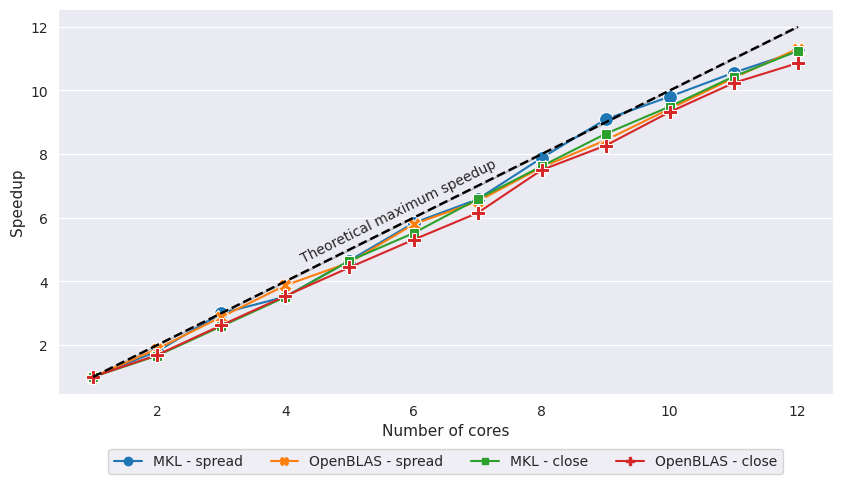

In [88]:
# Plot the results - speedup

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='n_cores',
             y='speedup', 
             hue='test', 
             data=cs_thin_float, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
## Theoretical maximum speedup line
sns.lineplot(x='n_cores', y='n_cores', data=cs_thin_float, color='black', linestyle='--', linewidth=1.75)
plt.text(x=5.775, y=6.225, s='Theoretical maximum speedup', va='center', ha='center', rotation=45, rotation_mode='anchor', transform_rotates_text=True)
## Styling
sns.set_style('darkgrid')
plt.ylabel('Speedup', fontsize=11)
plt.xlabel('Number of cores', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/core_scaling_thin_float.png', dpi=250, bbox_inches='tight')
plt.show()

Core scalability of THIN nodes is better than EPYC nodes. The speedup is almost linear.

It has been decided to stop here the analysis and not to go further with the efficiency.

## THIN nodes - double precision

In [89]:
# Gather data for the plot

node = 'THIN'
precision = 'double'

policy = 'spread'
cs_mkl_double_spread = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_double_spread = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node, 
    precision=precision, 
    policy=policy
)

policy = 'close'
cs_mkl_double_close = get_summary(
    test = 'core_scaling',
    lib = 'mkl',
    node=node, 
    precision=precision, 
    policy=policy
)
cs_oblas_double_close = get_summary(
    test = 'core_scaling',
    lib = 'oblas',
    node=node,
    precision=precision,
    policy=policy
)

## Add discriminant column to differentiate tests
cs_mkl_double_spread['test'] = 'MKL - spread'
cs_oblas_double_spread['test'] = 'OpenBLAS - spread'
cs_mkl_double_close['test'] = 'MKL - close'
cs_oblas_double_close['test'] = 'OpenBLAS - close'

## Concatenate dataframes
cs_thin_double = pd.concat([
    cs_mkl_double_spread, 
    cs_oblas_double_spread, 
    cs_mkl_double_close, 
    cs_oblas_double_close
    ])

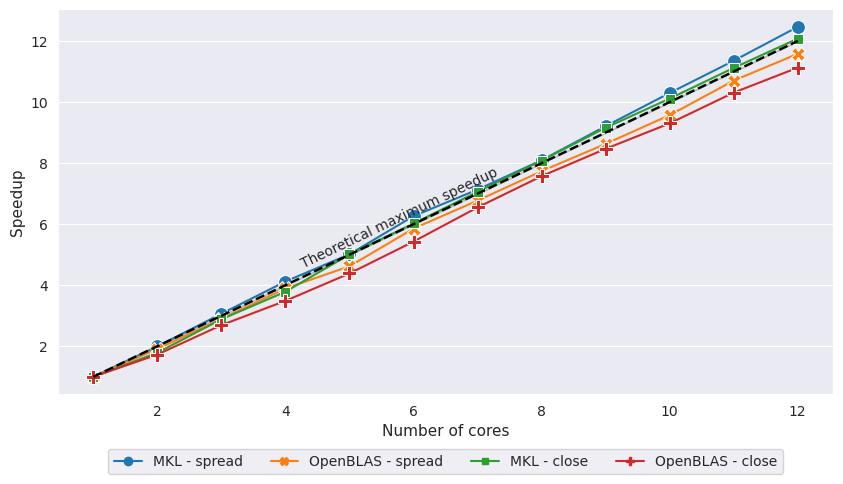

In [90]:
# Plot the results - speedup

plt.figure(figsize=(10, 5))

## Result lines
sns.lineplot(x='n_cores',
             y='speedup', 
             hue='test', 
             data=cs_thin_double, 
             markers=True, 
             markersize=10, 
             style='test', 
             dashes=False
             )
## Theoretical maximum speedup line
sns.lineplot(x='n_cores', y='n_cores', data=cs_thin_double, color='black', linestyle='--', linewidth=1.75)
plt.text(x=5.775, y=6.225, s='Theoretical maximum speedup', va='center', ha='center', rotation=45, rotation_mode='anchor', transform_rotates_text=True)
## Styling
sns.set_style('darkgrid')
plt.ylabel('Speedup', fontsize=11)
plt.xlabel('Number of cores', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.225), loc='lower center', ncol=4, title='')
plt.grid(False, axis='x')
## Save and show plot
plt.savefig('assets/core_scaling_thin_double.png', dpi=250, bbox_inches='tight')
plt.show()

For both single and double precision MKL shows the best results, even going over the theoretical maximum speedup, this may be due to caching effects.

Also OpenBLAS performs quite well.